[FINM 33150] Regression Analysis and Quantitative Trading Strategies\
Winter 2022 | Professor Brian Boonstra

# HW #5 FX Carry Strategy

_**Due:** Thursday, February 17th, at 11:00pm\
**Name:** Ashley Tsoi (atsoi, Student ID: 12286230)_

### 1. Fetch and clean data

#### 1-1. Import packages

In [1]:
import os
from pathlib import Path
import functools
# from tqdm.notebook import tqdm_notebook as tqdm
import warnings

import quandl
import json
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from pandas.tseries.offsets import DateOffset
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# import math
import numpy as np
import statsmodels.api as sm
import datetime as dt
# from dateutil.relativedelta import relativedelta

# let plot display in the notebook instead of in a different window
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [21, 8]
import seaborn as sns

#### 1-2. Fetch data

**1-2-1.**

In [ ]:
# Define function that retrieves EOD data from Quandl
@functools.lru_cache(maxsize=16) # Cache the function output
def getQuandlYCData(yc,start_date,end_date,columns):
    # Get one security (sec)'s data fom Quandl using quandl.get_table
    # NOTE: missing data for the inputted date will NOT return a row.

    # INPUT         | DATA TYPE                 | DESCRIPTION
    # yc            | string / list of string   | yield curve
    # start_date    | string (YYYY-MM-DD)       | start date of data
    # end_date      | string (YYYY-MM-DD)       | end date of data (same as or after start_date)
    # columns       | string / list of string   | columns to return
    
    print(f"Quandl | START | Retriving Quandl data for yield curve: {yc}\n")
    
    # Retrieve data using quandl.get_table
    quandl.ApiConfig.api_key = APIs['Quandl']
    data = quandl.get('YC/'+yc,
                      date = {'gte':start_date, 'lte':end_date},
                      qopts = {'columns':list(columns)}
                      )

    print(f"Quandl | DONE  | Returning {len(data):d} dates of data for {sec}.\n")
    return data


    start_dt = '2009-01-01'
end_dt = '2022-01-31'
get_quandl_data('YC','GBR_ISSC',start_dt,end_dt)


#### 2-2. Calculate trading results

In [13]:
def calcTradeStats(table,price_col_name,init_cash):
    # table must contain columns (1) price*volumn (2) position
    # returns columns: [table.columns] + [signal, position_value, cash, total_value, PnL_daily, PnL_cumulative]

    if price_col_name not in table.columns: raise ValueError(f'{price_col_name} must be a table column.')
    if 'position' not in table.columns: raise ValueError('position must be a table column.')

    table['signal'] = [table.position[0]] + table.position.diff()[1:].astype(np.int16).tolist()
    table['position_value'] = table[price_col_name] * table.position
    table['cash'] = np.cumsum([init_cash-table.position_value[0]] + (-1*(table.signal*table[price_col_name])[1:]).tolist())
    table['total_value'] = table.position_value + table.cash
    table['PnL'] = table.total_value.pct_change().fillna(0)
    table['PnL_cumulative'] = table.total_value/init_cash - 1

    return table

In [14]:
for j in j_range:
    for t in sec_range:
        for t_name,t_data in positions_tables[j][t].items():
            positions_tables[j][t][t_name] = calcTradeStats(t_data,'PriceMillionths',1000000)

#### 2-3. Display trading results

**2-3-1. See overall performance**

In [15]:
# initialize heatmap data
c = pd.MultiIndex.from_product([j_range, ['bu','eb','eu']], names=['j', 'pairs'])
PnL_max = pd.DataFrame(columns=c,index=sec_range)
PnL_cumulative = pd.DataFrame(columns=c,index=sec_range)
n_trades = pd.DataFrame(columns=c,index=sec_range)

for j in j_range:
    for t in sec_range:
        for t_name,t_data in positions_tables[j][t].items():
            PnL_max.loc[t,(j,t_name)] = t_data.PnL.max()
            PnL_cumulative.loc[t,(j,t_name)] = t_data.PnL_cumulative[-1]
            n_trades.loc[t,(j,t_name)] = np.sum(abs(t_data.signal))

In [16]:
PnL_max.fillna(0)

j     0.0005            0.0007            0.0009            0.0011  ...  \
pairs     bu     eb  eu     bu     eb  eu     bu     eb  eu     bu  ...   
1        inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf    inf  ...   
5        inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf    inf  ...   
10       inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf    inf  ...   
60       inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf    inf  ...   
120      inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf    inf  ...   
300      inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf    inf  ...   
3600     inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf    inf  ...   

j     0.0013 0.0015            0.0017            0.0019             
pairs     eu     bu     eb  eu     bu     eb  eu     bu     eb  eu  
1        inf    inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf  
5        inf    inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf  
10       inf    inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf  
60       inf    inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf  
120      inf    inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf  
300      inf    inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf  
3600     inf    inf 0.0000 inf    inf 0.0000 inf    inf 0.0000 inf  

[7 rows x 24 columns]

In [17]:
PnL_cumulative.fillna(0)

j        0.0005                  0.0007                  0.0009                \
pairs        bu     eb     eu        bu     eb     eu        bu     eb     eu   
1     1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
5     1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
10    1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
60    1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
120   1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
300   1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
3600  1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   

j        0.0011  ... 0.0013    0.0015                  0.0017                \
pairs        bu  ...     eu        bu     eb     eu        bu     eb     eu   
1     1071.5100  ... 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
5     1071.5100  ... 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
10    1071.5100  ... 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
60    1071.5100  ... 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
120   1071.5100  ... 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
300   1071.5100  ... 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   
3600  1071.5100  ... 7.2000 1071.5100 0.0018 7.2000 1071.5100 0.0018 7.2000   

j        0.0019                
pairs        bu     eb     eu  
1     1071.5100 0.0018 7.2000  
5     1071.5100 0.0018 7.2000  
10    1071.5100 0.0018 7.2000  
60    1071.5100 0.0018 7.2000  
120   1071.5100 0.0018 7.2000  
300   1071.5100 0.0018 7.2000  
3600  1071.5100 0.0018 7.2000  

[7 rows x 24 columns]

In [18]:
n_trades.fillna(0)

j     0.0005           0.0007           0.0009           0.0011  ... 0.0013  \
pairs     bu   eb   eu     bu   eb   eu     bu   eb   eu     bu  ...     eu   
1       2094  226  242   2094  226  242   2094  226  242   2094  ...    242   
5       2094  226  242   2094  226  242   2094  226  242   2094  ...    242   
10      2094  226  242   2094  226  242   2094  226  242   2094  ...    242   
60      2094  226  242   2094  226  242   2094  226  242   2094  ...    242   
120     2094  226  242   2094  226  242   2094  226  242   2094  ...    242   
300     2094  226  242   2094  226  242   2094  226  242   2094  ...    242   
3600    2094  226  242   2094  226  242   2094  226  242   2094  ...    242   

j     0.0015           0.0017           0.0019            
pairs     bu   eb   eu     bu   eb   eu     bu   eb   eu  
1       2094  226  242   2094  226  242   2094  226  242  
5       2094  226  242   2094  226  242   2094  226  242  
10      2094  226  242   2094  226  242   2094  226  242  
60      2094  226  242   2094  226  242   2094  226  242  
120     2094  226  242   2094  226  242   2094  226  242  
300     2094  226  242   2094  226  242   2094  226  242  
3600    2094  226  242   2094  226  242   2094  226  242  

[7 rows x 24 columns]

**2-3-2. Define function to plot result**

In [19]:
def plotTradeSim(tradeSim,price_col_name,j):

    plt.clf() # clear previous plots

    tp = plt

    tp.title('preaCumulative Return Sd and Trades')

    tp.plot(tradeSim[price_col_name], label='Price Millionths')
    
    # tp.plot(tradeSim[price_col_name][tradeSim.signal>=1], color='green', marker='o', markersize=6, linestyle='none')
    tp.plot(tradeSim[price_col_name][tradeSim.signal>=1], color='green', marker='o', markersize=4, linestyle='none', label='buy signal')
    tp.plot(tradeSim[price_col_name][tradeSim.signal<=-1], color='red', marker='o', markersize=4, linestyle='none', label='sell signal')
    # tp.plot(tradeSim[price_col_name][tradeSim.signal<=-1], color='red', marker='o', markersize=6, linestyle='none')
    
    tp.fill_between(tradeSim.index, -j, j, color='grey', alpha=.3, label='j (threshold)')

    tp.legend()

    return tp

<module 'matplotlib.pyplot' from 'C:\\Users\\ashle\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

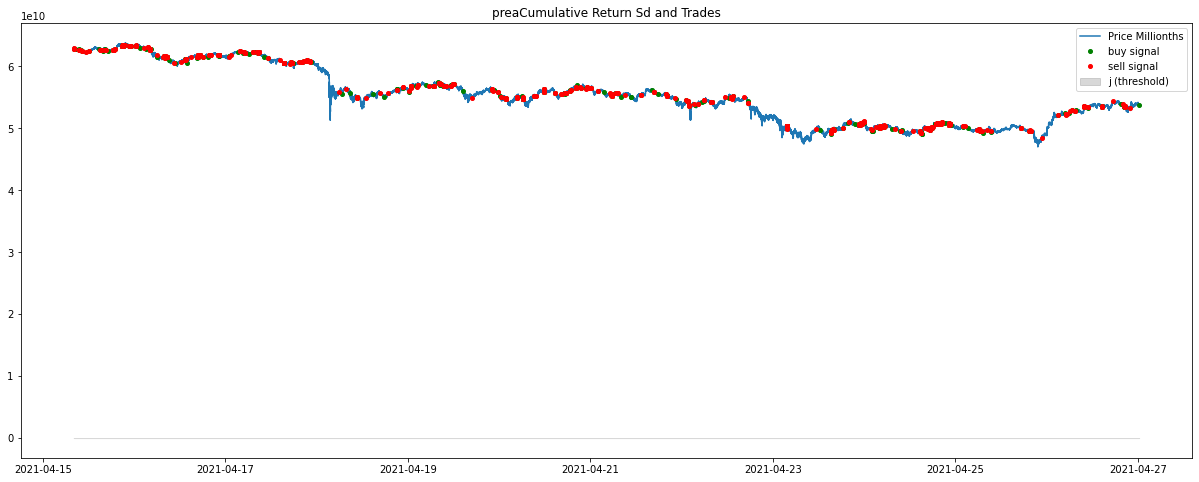

In [22]:
plotTradeSim(positions_tables[0.0005][1]['bu'],'PriceMillionths',0.0005)